In [1]:
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pingouin as pg

In [2]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


import plotting as pl
from models import model as md
import utils as ut

first, extract relevant results from disk

In [3]:
# by-participant embedding models (no by-participant decision models)
l_rnd_seed = ['998877']
l_temperature = [0.009999999776482582, 100.0]
lmbda = [0.0005]
l_n = [5, 10]
lmbda_hierarchical = [0.0]
modelversion = "avg-ID-jointly-embeddings"
l_sparse = ["both"]
l_splithalf = ["1", "2"]
l_subjecttype = ["subjects_actual"]
l_splithalf_1 = ut.extract_split_half(
    lmbda, lmbda_hierarchical, l_rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="free_weights",
    l_temperature=l_temperature
)
lmbda_hierarchical = [0.01]
l_sparse = ["items_and_random_ids"]
l_splithalf_2 = ut.extract_split_half(
    lmbda, lmbda_hierarchical, l_rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights",
    l_temperature=l_temperature
)
modelversion = "avg-ID-jointly-embeddings-decision"
l_n = [2, 3, 4, 5, 6, 7, 8, 9, 10]
l_rnd_seed = [1, 3, 4, 5]
l_splithalf_3 = ut.extract_split_half(
    lmbda, lmbda_hierarchical, l_rnd_seed, modelversion, l_n, l_sparse,
    l_subjecttype, l_splithalf, modeltype="random_weights_random_scaling",
)

In [4]:
l_splithalf = l_splithalf_1 + l_splithalf_2 + l_splithalf_3

- first, just extract the similarities for further processing
- then, reorder dimensions, such that maximally correlated dimensions align in both splits
- then, extract the indices of the fits for which each dim in split 1 has a different maximally similar dim in split 2
- then, plot the distribution of max similarities to see how much dimensions match

In [5]:
range_dims = range(2, 11) # currently from 2 to 10

In [6]:
partial_sims = partial(ut.dimensional_similarities, l_splithalf_3)
l_cors = list(map(partial_sims, l_n))

In [7]:
partial_reorder = partial(ut.reorder_dimensions, l_splithalf_3)
l_max_sims = list(map(partial_reorder, l_n))

In [8]:
dict_idxs_use = ut.max_sim_dimensions_per_ndim(l_max_sims, range_dims)
dict_idxs_list_use = ut.max_sim_results_per_ndim(dict_idxs_use, l_max_sims, range_dims)

In [9]:
df_cors = ut.max_cors(range(2, 11), dict_idxs_use, l_cors)

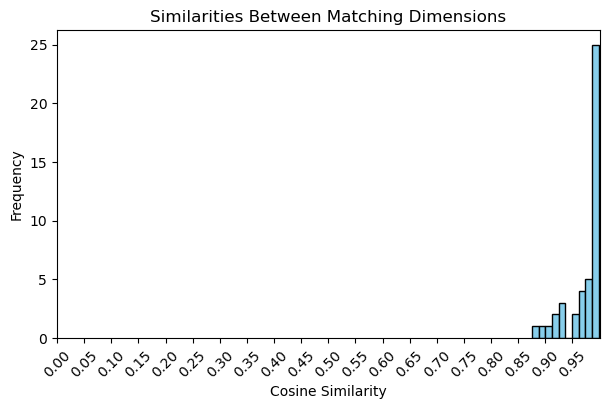

In [10]:
df_cors_long = df_cors.melt(value_name="r", var_name="ndim")
df_cors_long_plt = df_cors_long.query("not r.isna()")
# Create histogram
plt.figure(figsize=(7, 4))
plt.hist(df_cors_long_plt['r'], bins=10, color='skyblue', edgecolor='black')
plt.xticks(np.arange(0, 1, .05), rotation=45)
plt.xlim((0, 1))
plt.title("Similarities Between Matching Dimensions")
plt.xlabel("Cosine Similarity")
_ = plt.ylabel("Frequency")

manually select the relevant decision weight matrices and then compute the reliabilities per dimension

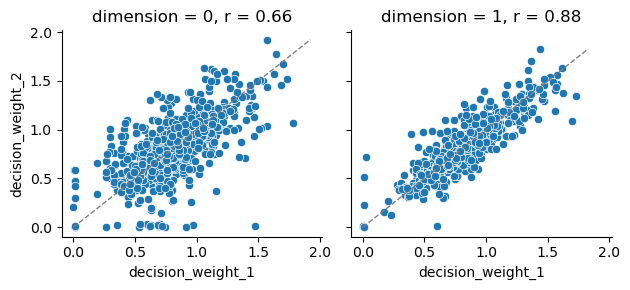

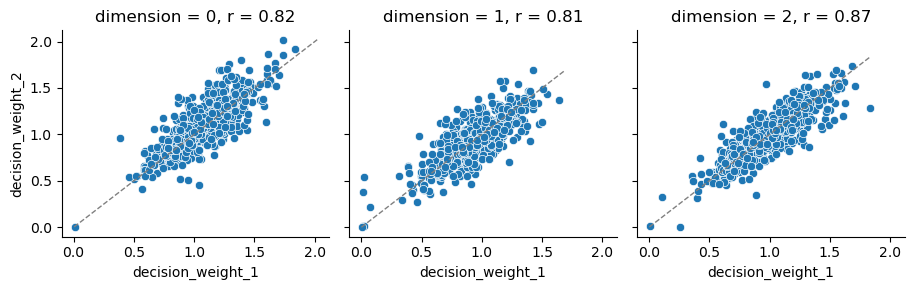

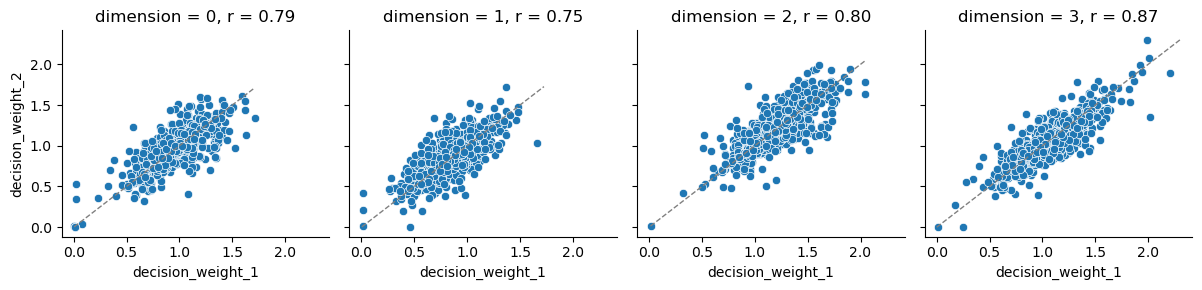

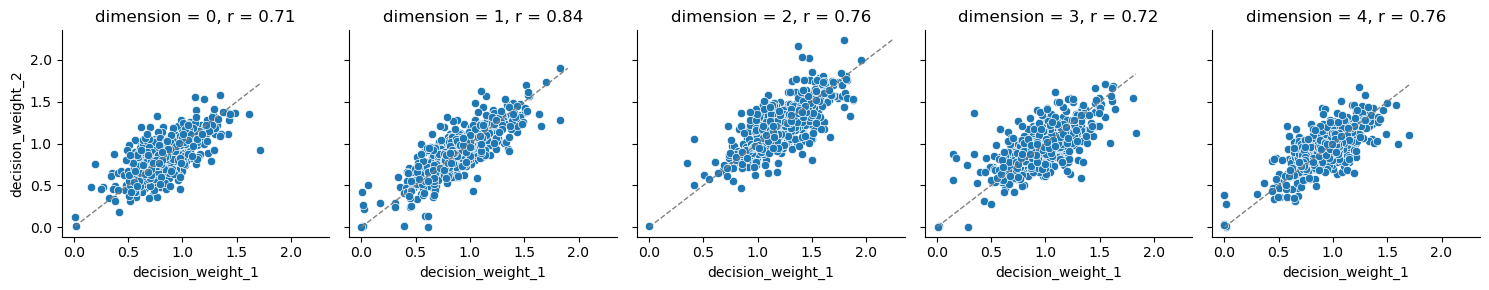

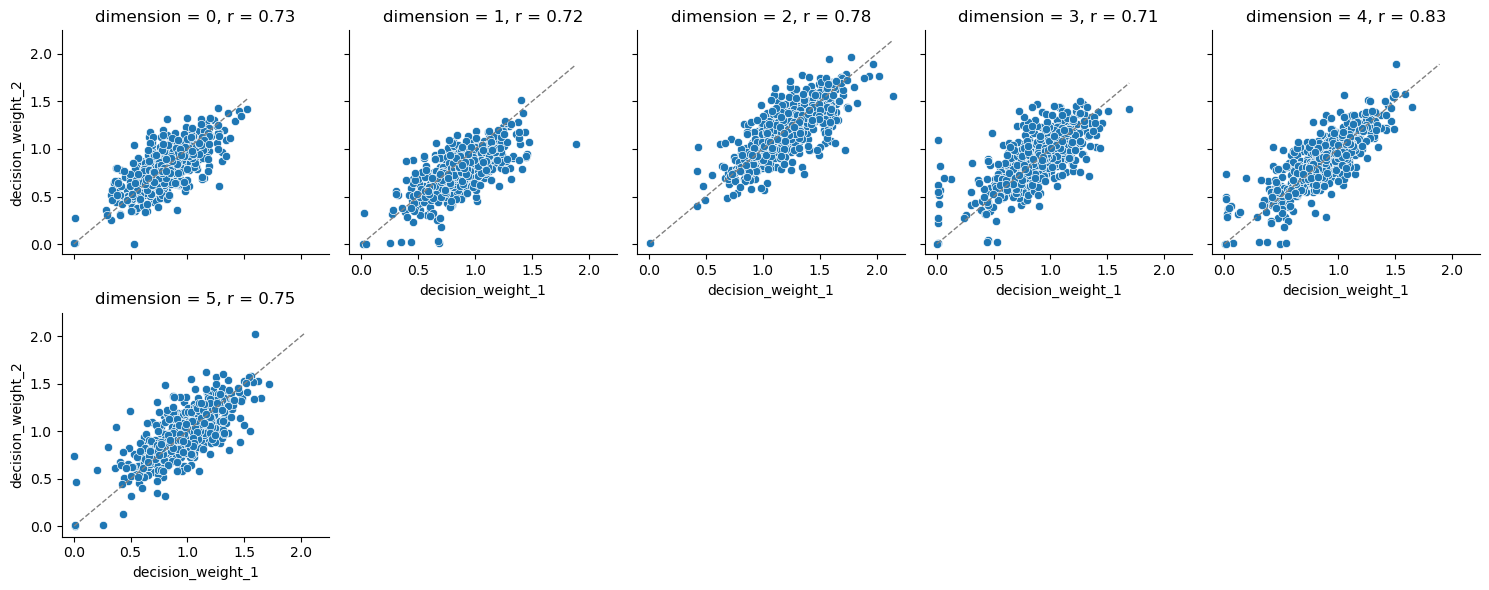

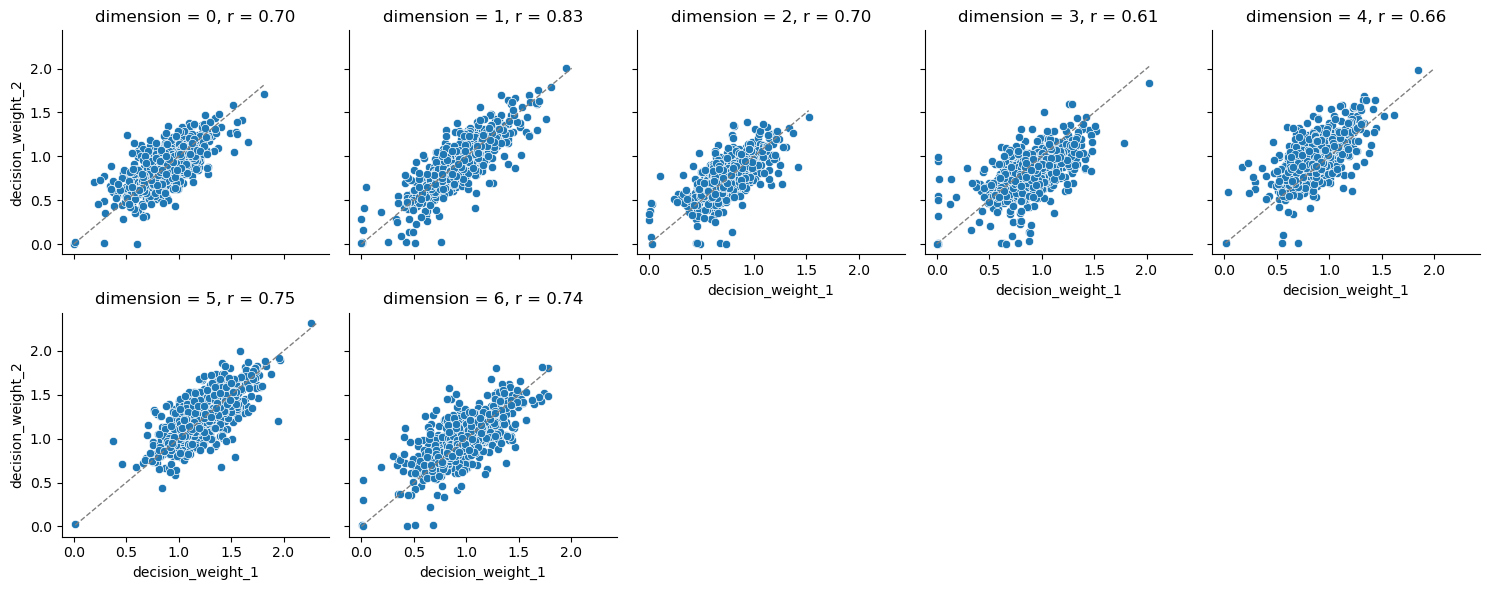

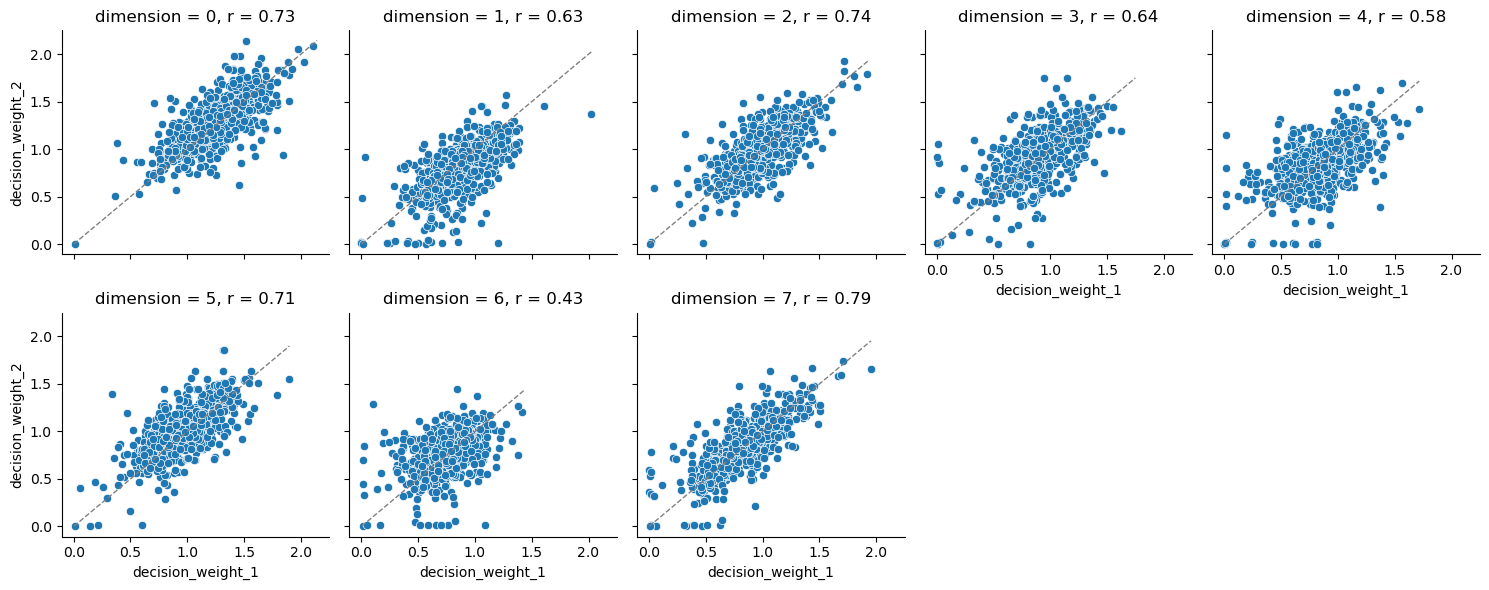

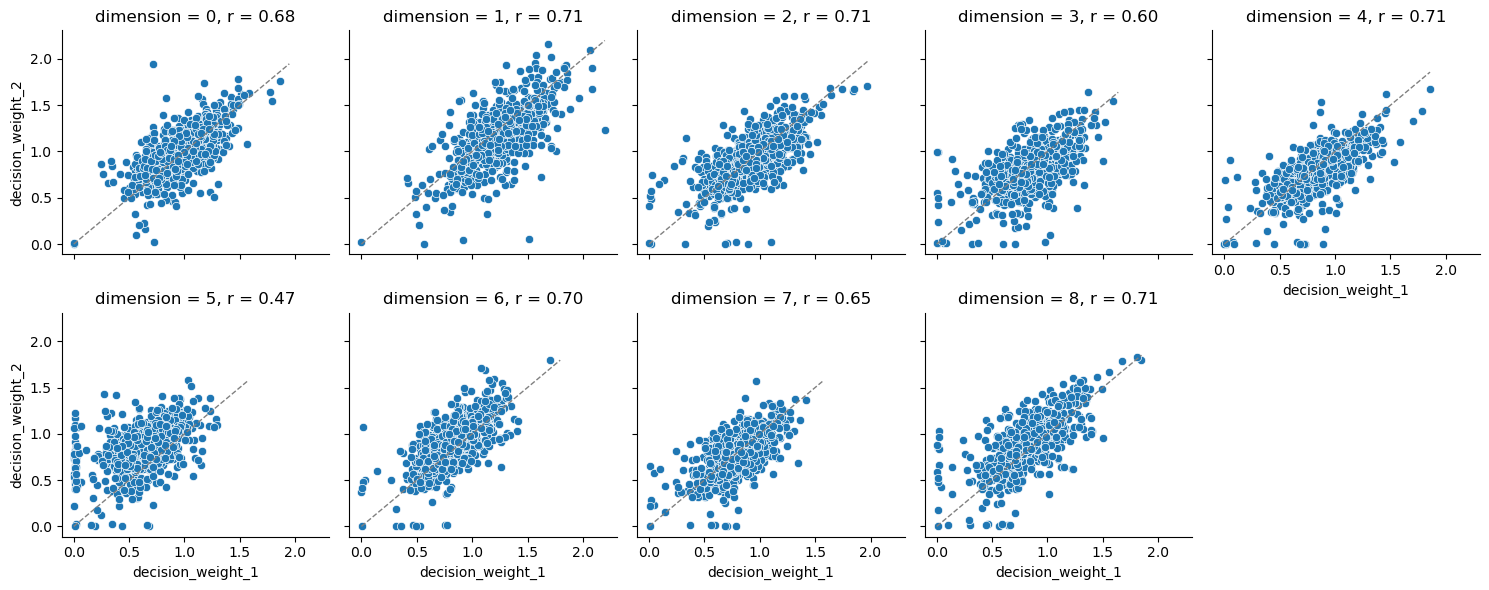

In [11]:
df_sh_2, df_corr_2, g_2 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[2], 2)
df_sh_3, df_corr_3, g_3 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[3], 3)
df_sh_4, df_corr_4, g_4 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[4], 4)
df_sh_5, df_corr_5, g_5 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[5], 5)
df_sh_6, df_corr_6, g_6 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[6], 6)
df_sh_7, df_corr_7, g_7 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[7], 7)
df_sh_8, df_corr_8, g_8 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[8], 8)
df_sh_9, df_corr_9, g_9 = ut.split_half_reliabilities(l_splithalf_3, dict_idxs_list_use[9], 9)

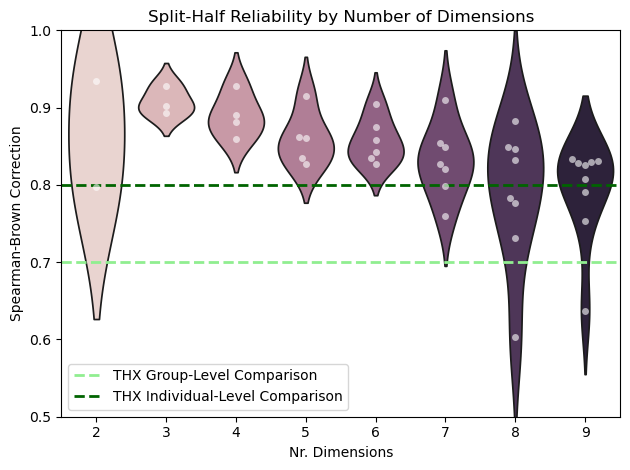

In [12]:
df_corrs = pd.concat([df_corr_2, df_corr_3, df_corr_4, df_corr_5, df_corr_6, df_corr_7, df_corr_8, df_corr_9], axis=0)
# spearman-brown prophecy correction
df_corrs["r_corrected"] = (2*df_corrs["r"])/(1 + df_corrs["r"])

# Violin plot
sns.violinplot(data=df_corrs, x="ndims", y="r_corrected", hue="ndims", inner=None, legend=False)

# Swarm plot on top
sns.swarmplot(data=df_corrs, x="ndims", y="r_corrected",  color="white", alpha=0.6, legend=False)

plt.axhline(y=.7, color='lightgreen', linestyle='--', linewidth=2, label='THX Group-Level Comparison')
plt.axhline(y=.8, color='darkgreen', linestyle='--', linewidth=2, label='THX Individual-Level Comparison')

plt.xlabel("Nr. Dimensions")
plt.ylabel("Spearman-Brown Correction")


# Remove duplicate legend
plt.legend()
plt.ylim((.5, 1))
plt.title("Split-Half Reliability by Number of Dimensions")
plt.tight_layout()

In [13]:
df_sh_6["delta_decision_weight"] = df_sh_6["decision_weight_2"] - df_sh_6["decision_weight_1"]
df_sh_6["abs_delta_decision_weight"] = np.abs(df_sh_6["delta_decision_weight"])
avg_abs_delta = df_sh_6.groupby("id")["abs_delta_decision_weight"].agg("mean").reset_index()
avg_abs_delta.head()

,id,abs_delta_decision_weight
0,0,0.097297
1,1,0.118785
2,2,0.187956
3,3,0.208440
4,4,0.325618


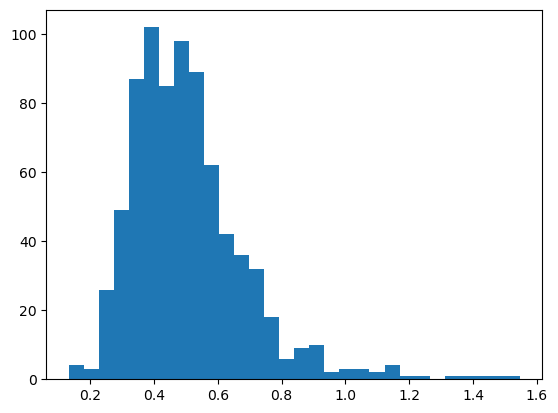

In [14]:
df_plt = df_sh_6.groupby("id")["decision_weight_1"].agg(lambda x: x.max() - x.min()).reset_index()
_ = plt.hist(df_plt["decision_weight_1"], bins=30)

In [15]:
df_sh_6.sort_values(["decision_weight_1"], ascending=False).head()

,id,dimension,decision_weight_1,timepoint_1,decision_weight_2,timepoint_2,delta_decision_weight,abs_delta_decision_weight
1636,78,2,2.140048,1,1.554171,2,-0.585876,0.585876
1764,206,2,2.021352,1,1.761875,2,-0.259476,0.259476
2308,750,2,1.971975,1,1.888246,2,-0.083729,0.083729
1641,83,2,1.930627,1,1.764380,2,-0.166247,0.166247
2205,647,2,1.893419,1,1.744449,2,-0.148970,0.148970


In [16]:
df_sh_6.sort_values(["id", "dimension"]).head()

,id,dimension,decision_weight_1,timepoint_1,decision_weight_2,timepoint_2,delta_decision_weight,abs_delta_decision_weight
0,0,0,0.655647,1,0.796585,2,0.140938,0.140938
779,0,1,0.771585,1,0.706938,2,-0.064648,0.064648
1558,0,2,0.995402,1,1.113236,2,0.117834,0.117834
2337,0,3,0.846848,1,0.815637,2,-0.031211,0.031211
3116,0,4,0.727855,1,0.775284,2,0.047428,0.047428


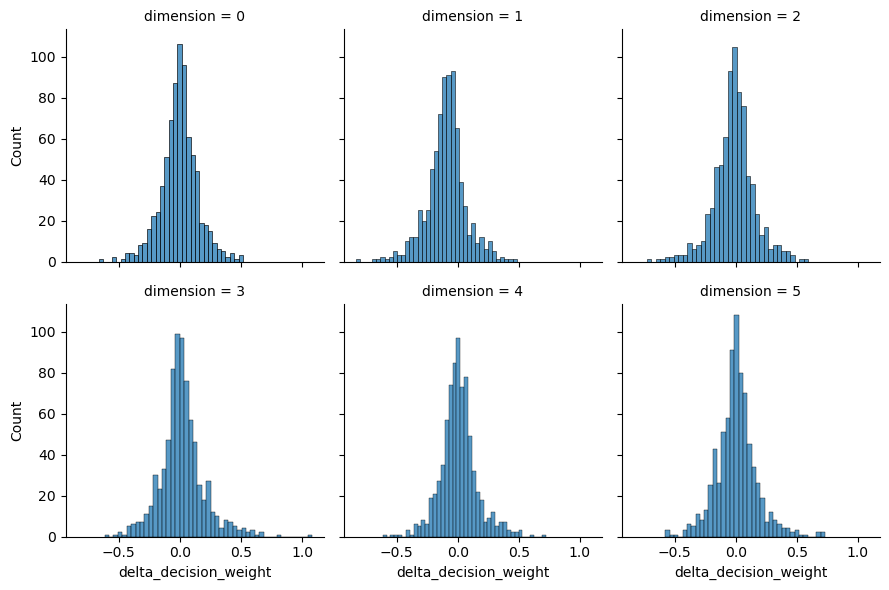

In [17]:
g = sns.FacetGrid(data=df_sh_6, col="dimension", col_wrap=3)
_ = g.map_dataframe(sns.histplot, x="delta_decision_weight")

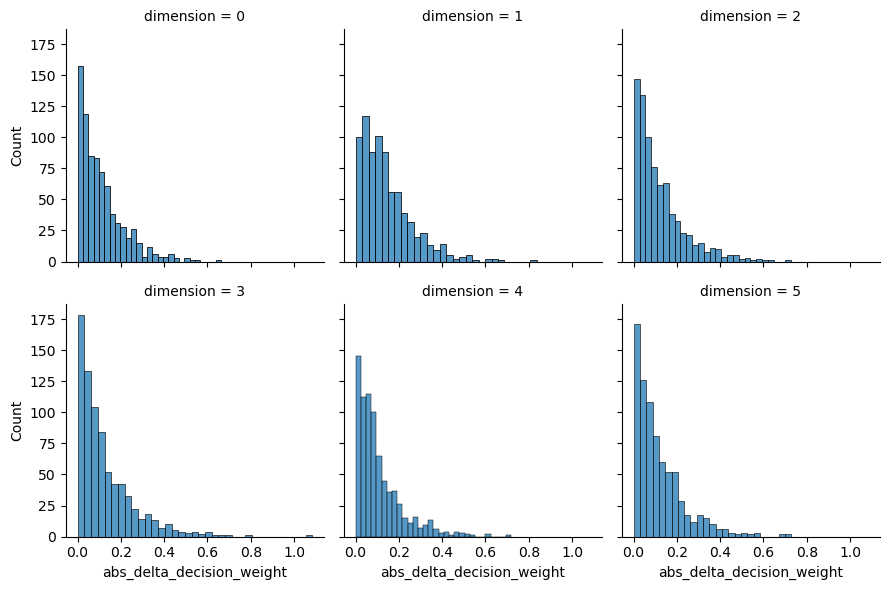

In [18]:
g = sns.FacetGrid(data=df_sh_6, col="dimension", col_wrap=3)
_ = g.map_dataframe(sns.histplot, x="abs_delta_decision_weight")

In [19]:
# up- and downward movements in dimension weights is shared across dimensions:
icc_decision_weights = pg.intraclass_corr(data=df_sh_6, targets='id', raters='dimension', ratings='delta_decision_weight')
# distribution of weights across dimensions is quite stable across timepoints
# i.e., either you weigh equally all the time, or you up- and downweigh equally across splits
ginis = df_sh_6.groupby("id")[["decision_weight_1", "decision_weight_2"]].agg(ut.gini).reset_index()
icc_ginis = pg.intraclass_corr(data=ginis.melt(id_vars="id"), targets='id', raters='variable', ratings='value')
# given gini coef is stable across sessions, let us just take the average:
ginis_avg = ginis[["decision_weight_1", "decision_weight_2"]].mean(axis=1).reset_index()
ginis_avg["id"] = ginis["id"].copy()
ginis_avg.drop(columns="index", inplace=True)
ginis_avg.columns = ["avg_gini", "id"]
ginis_avg = ginis_avg[["id", "avg_gini"]]
# merge gini with abs deltas: are they positively related? i.e., larger changes lead to larger dimensional inequality?
df_gini_abs_delta = pd.merge(ginis_avg, avg_abs_delta, on="id", how="left")
# seems to be the case, but effect is rather small (see bivariate plot below)

In [20]:
icc_decision_weights.query("Type == 'ICC3'")

,Type,Description,ICC,F,df1,df2,pval,CI95%
2,ICC3,Single fixed raters,0.478103,6.496531,778,3890,0.0,"[0.45, 0.51]"


In [21]:
icc_ginis.query("Type == 'ICC3'")

,Type,Description,ICC,F,df1,df2,pval,CI95%
2,ICC3,Single fixed raters,0.746349,6.884858,778,778,5.232923e-140,"[0.71, 0.78]"


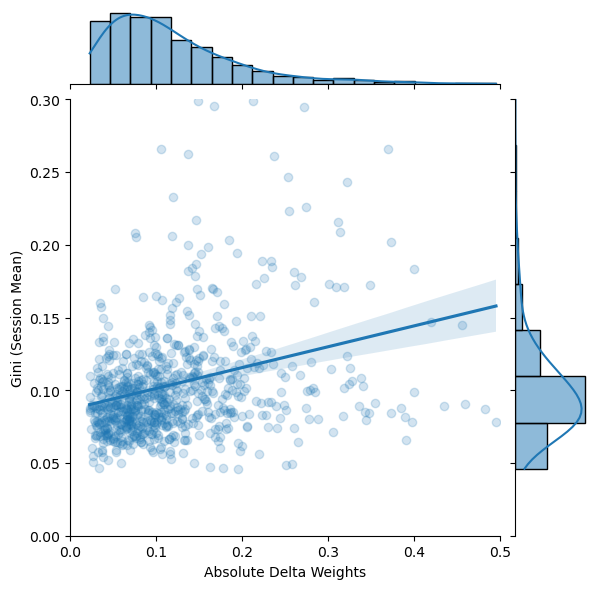

In [22]:
sns.jointplot(
    data=df_gini_abs_delta,
    x="abs_delta_decision_weight",
    y="avg_gini",
    kind="reg",
    marginal_kws=dict(bins=20, fill=True),
    joint_kws=dict(scatter_kws={'alpha': 0.2})  # Specifically for the points
)
plt.ylim((0, .3))
plt.xlim((0, .5))
plt.ylabel("Gini (Session Mean)")
_ = plt.xlabel("Absolute Delta Weights")